## MTH9845 Risk Management Model Validation report


* Author: Hongchao Pan, Yu Sun
* Kernel version: Python 3.5
* Packages: numpy, pandas, matplotlib, scipy, math
* Data: 
    * Volatility matrices of EUR/USD and GBP/USD were obtained from Bloomberg
    * Benchmark prices were obtained from Bloomberg pricing model and *investing.com*
    * Interest rates (foreign and domestic) were obtained from *tradingeconomics.com*
* Notes:


In [1]:
# Loading packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math

In [2]:
# Get the data from excel file
df=pd.read_excel(io='Testing-data/VolMatrix/Vol-matrix.xlsx',sheetname=0,parse_cols="A:F",skiprows=2)
df['25DC']=df['ATM']+df['25DBF']+0.5*df['25DRR']
df['25DP']=df['ATM']+df['25DBF']-0.5*df['25DRR']
df['10DC']=df['ATM']+df['10DBF']+0.5*df['10DRR']
df['10DP']=df['ATM']+df['10DBF']-0.5*df['10DRR']
df.iloc[:,1:]=df.iloc[:,1:]/100  # Change the percentage number to decimal
df

,Mid Vol,ATM,25DRR,25DBF,10DRR,10DBF,25DC,25DP,10DC,10DP
0,EUR/USD,0.071125,0.000900,0.001925,0.001450,0.00570,0.073500,0.072600,0.077550,0.076100
1,GBP/USD,0.067125,-0.002800,0.002275,-0.004825,0.00635,0.068000,0.070800,0.071063,0.075887
2,USD/JPY,0.082550,-0.004125,0.002225,-0.007750,0.00615,0.082712,0.086837,0.084825,0.092575


In [3]:
# Get the data from excel file 1Y data
df2=pd.read_excel(io='Testing-data/VolMatrix/Vol-matrix_1Y.xlsx',sheetname=0,parse_cols="A:F",skiprows=1)
df2['25DC']=df2['ATM']+df2['25DBF']+0.5*df2['25DRR']
df2['25DP']=df2['ATM']+df2['25DBF']-0.5*df2['25DRR']
df2['10DC']=df2['ATM']+df2['10DBF']+0.5*df2['10DRR']
df2['10DP']=df2['ATM']+df2['10DBF']-0.5*df2['10DRR']
df2.iloc[:,1:]=df2.iloc[:,1:]/100  # Change the percentage number to decimal
df2

,Mid Vol,ATM,25DRR,25DBF,10DRR,10DBF,25DC,25DP,10DC,10DP
0,EUR/USD,0.07415,-0.00685,0.00325,-0.01175,0.01065,0.073975,0.080825,0.078925,0.090675


In [4]:
# K is given with the reference on inversting.com
K_ATMEURUSD=[1.065,1.07,1.075,1.08,1.085]
#K_ATMGBPUSD=[1.27,1.275,1.28,1.285,1.29]
K_ATMUSDJPY=[110,110.5,112,112.5,113]
# 1Y
K_ATMEURUSD1Y=[1.05,1.06,1.07,1.08,1.09]
# Delta
Deltas=[0.25,0.1]
# S0
S0s=[1.0867,1.2933,113.38]
    #EURUSD,GBP/USD
S0s1Y=[1.0923] #EURUSD
T=33/360 # 33days
T1Y=367/360 # 1Y
# foregin/domestic interest rates
rfs=[0,0,1/100] # EUR,GBP,USD
rds=[1/100,1/100,-0.1/100] # USD,USD,JPY

In [5]:
# Implement the Black-Scholes model in FX derivetives
# The volatility used for BS is ATM vol
# Define d1
def d_1(t,S,K,T,sigma,rd,rf):
    '''
    param t: spot time, usually is 0
    param S: spot price: exchange rate
    param K: given strike
    param T: maturity with unit year
    param sigma: volatility
    param rd: domestic interest rate
    param rf: foreign interest rate
    return d1 in BS formula
    '''
    return (math.log(S/K)+(rd-rf+0.5*math.pow(sigma,2))*(T-t))/(sigma*math.sqrt(T-t))

def BS_FX(t,S,K,T,sigma,rd,rf,flag,optflag):
    '''
    param t: spot time, usually is 0
    param S: spot price: exchange rate
    param K: given strike
    param T: maturity with unit year
    param sigma: volatility
    param rd: domestic interest rate
    param rf: foreign interest rate
    param flag: call/put indicator
    param optflag: output price or greeks
    '''
    d1=d_1(t,S,K,T,sigma,rd,rf)
    d2=d1-sigma*np.sqrt(T-t)
    
    call_price=S*math.exp(-rf*(T-t))*norm.cdf(d1)-K*math.exp(-rd*(T-t))*norm.cdf(d2)
    put_price=K*math.exp(-rd*(T-t))*norm.cdf(-d2)-S*math.exp(-rf*(T-t))*norm.cdf(-d1)
    
    vega=S*math.exp(-rf*(T-t))*math.sqrt(T-t)*math.exp(-0.5*d1*d1)/math.sqrt(2*math.pi)
    
    if optflag.upper() =='VEGA':
        return vega
    if optflag.upper() == 'PRICE':
        if flag.upper() == 'CALL':
            return call_price
        if flag.upper() =="PUT":
            return put_price

In [6]:
# Define functions to compute Vanna and Volga
def Vanna_Volga(t,S,K,T,sigma,rd,rf,flag,optflag):
    '''
    param t: spot time, usually is 0
    param S: spot price: exchange rate
    param K: given strike
    param T: maturity with unit year
    param sigma: volatility
    param rd: domestic interest rate
    param rf: foreign interest rate
    param flag: call/put indicator
    param optflag: output Vanna or Volga
    '''
    d1=d_1(t,S,K,T,sigma,rd,rf)
    d2=d1-sigma*np.sqrt(T-t)
    
    vega=BS_FX(t,S,K,T,sigma,rd,rf,flag,"VEGA")
    
    vanna=-vega*d2/(S*sigma*np.sqrt(T-t))
    
    volga= vega*d1*d2/sigma
    
    if optflag.upper()=="VANNA":
        return vanna
    if optflag.upper()=="VOLGA":
        return volga
     

In [7]:
# Define function to compute Kc and Kp
def K_cp(t,S,T,sigma,rd,rf,flag,Delta):
    '''
    param t: spot time, usually is 0
    param S: spot price: exchange rate
    param T: maturity with unit year
    param sigma: volatility
    param rd: domestic interest rate
    param rf: foreign interest rate
    param flag: call/put indicator
    param Delta: Delta 0.25 or 0.1
    '''

    if flag.upper()=="PUT":
        phi=1
    if flag.upper()=="CALL":
        phi=1
    
    K=S*np.exp((rd-rf)*T-phi*sigma*np.sqrt(T)*norm.ppf(phi*Delta)+0.5*sigma*sigma*T)
#    print(S,rd,rf,phi,sigma,T,Delta)
    
    return K

In [8]:
# Implement Vanna-Volga model
def VannaVolga_Pricing(K_ATMs,S0,T,rd,rf,vols):
    '''
    param vols: contains vol of ATM, 25DC, 25DP, 10DC, 10DP
    '''
    price=[]
    # Compute the K25C, K25P, K10C, K10P
    K25C=K_cp(0,S0,T,vols[1],rd,rf,"CALL",0.25)
    K25P=K_cp(0,S0,T,vols[2],rd,rf,"PUT",0.25)
    K10C=K_cp(0,S0,T,vols[3],rd,rf,"CALL",0.1)
    K10P=K_cp(0,S0,T,vols[4],rd,rf,"PUT",0.1)

    for K in K_ATMs:
        BS_X=BS_FX(0,S0,K,T,vols[0],rd,rf,"CALL","PRICE")
        vanna_X=Vanna_Volga(0,S0,K,T,vols[0],rd,rf,"CALL","VANNA")
        volga_X=Vanna_Volga(0,S0,K,T,vols[0],rd,rf,"CALL","VOLGA")
        vanna_25=Vanna_Volga(0,S0,K,T,vols[1],rd,rf,"CALL","VANNA")
        volga_25=Vanna_Volga(0,S0,K,T,vols[1],rd,rf,"CALL","VOLGA")
        vanna_10=Vanna_Volga(0,S0,K,T,vols[2],rd,rf,"CALL","VANNA")
        volga_10=Vanna_Volga(0,S0,K,T,vols[2],rd,rf,"CALL","VOLGA")
        
        BS_25C=BS_FX(0,S0,K25C,T,vols[1],rd,rf,"CALL","PRICE")
        BS_25P=BS_FX(0,S0,K25P,T,vols[2],rd,rf,"PUT","PRICE")
        BS_10C=BS_FX(0,S0,K10C,T,vols[3],rd,rf,"CALL","PRICE")
        BS_10P=BS_FX(0,S0,K10P,T,vols[4],rd,rf,"PUT","PRICE")
        
        BS_25CATM=BS_FX(0,S0,K25C,T,vols[0],rd,rf,"CALL","PRICE")
        BS_25PATM=BS_FX(0,S0,K25P,T,vols[0],rd,rf,"PUT","PRICE")
        BS_10CATM=BS_FX(0,S0,K10C,T,vols[0],rd,rf,"CALL","PRICE")
        BS_10PATM=BS_FX(0,S0,K10P,T,vols[0],rd,rf,"PUT","PRICE")
        
        RR_cost25=(BS_25C-BS_25P)-(BS_25CATM-BS_25PATM)
        BF_cost25=0.5*(BS_25C+BS_25P)-0.5*(BS_25CATM+BS_25PATM)
        RR_cost10=(BS_10C-BS_10P)-(BS_10CATM-BS_10PATM)
        BF_cost10=0.5*(BS_10C+BS_10P)-0.5*(BS_10CATM+BS_10PATM)
        
#        print(K10P)
        P_VV=BS_X+vanna_X*RR_cost25/vanna_25+volga_X*BF_cost25/volga_25+vanna_X*RR_cost10/vanna_10+volga_X*BF_cost10/volga_10
        
        price.append(P_VV)
    
    return price
        
        

In [9]:
# Get the indices of vols
ind=[1,6,7,8,9]
vol_EURUSD=[df.iloc[0,i] for i in ind ]
#vol_GBPUSD=[df.iloc[1,i] for i in ind ]
vol_USDJPY=[df.iloc[0,i] for i in ind ]

# Get the price of EUR/USD
price_EURUSD=VannaVolga_Pricing(K_ATMEURUSD,S0s[0],T,rds[0],rfs[0],vol_EURUSD)
price_EURUSD=[i/S0s[0] for i in price_EURUSD]
# Get the price of GBP/USD
#price_GBPUSD=VannaVolga_Pricing(K_ATMGBPUSD,S0s[1],T,rds[1],rfs[1],vol_GBPUSD)
#price_GBPUSD=[i/S0s[1] for i in price_EURUSD]

# Get the BS price of EUR/USD
BS_EURUSD=[BS_FX(0,S0s[0],K,T,vol_EURUSD[0],rds[0],rfs[0],"CALL","PRICE") for K in K_ATMEURUSD]

# Get the BS price of GBP/USD
#BS_GBPUSD=[BS_FX(0,S0s[1],K,T,vol_GBPUSD[0],rds[1],rfs[1],"CALL","PRICE") for K in K_ATMGBPUSD]

# Get the price of USD/JPY
#price_USDJPY=VannaVolga_Pricing(K_ATMUSDJPY,S0s[2],T,rds[2],rfs[2],vol_USDJPY)
#price_USDJPY=[i/S0s[2] for i in price_USDJPY]
#price_USDJPY

In [10]:
# Benchmark prices
# EURUSD
bmpEU1=[0.022874,0.018981,0.015359,0.012075,0.009195]  # Bloomberg
bmpEU2=[0.0233,0.0195,0.0160,0.0128,0.0101] # inversting.com

# Create dataframe
df1M=pd.DataFrame({"EURUSD Strike":K_ATMEURUSD,"VV Price":price_EURUSD,
                  "BS Price":BS_EURUSD,"Heston Price":bmpEU1,
                 "investing.com Price":bmpEU2})
cols=['EURUSD Strike',"Heston Price","investing.com Price","BS Price",'VV Price']
# Change the columns order
dfres=df1M[cols]
dfres

,EURUSD Strike,Heston Price,investing.com Price,BS Price,VV Price
0,1.065,0.022874,0.0233,0.024682,0.023363
1,1.070,0.018981,0.0195,0.020663,0.019671
2,1.075,0.015359,0.0160,0.016970,0.016277
3,1.080,0.012075,0.0128,0.013649,0.013224
4,1.085,0.009195,0.0101,0.010733,0.010544


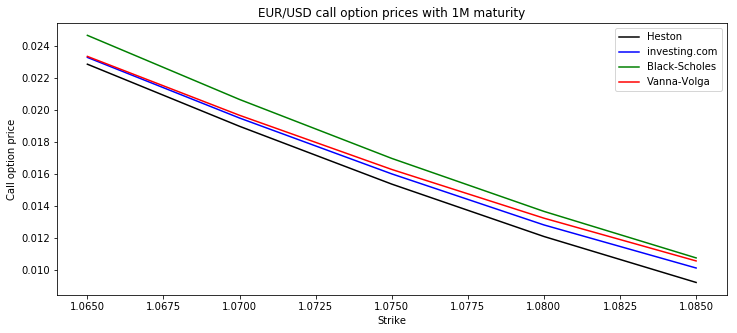

In [11]:
# Plot the four prices
plt.figure(1, figsize=(12,5))
plt.plot(dfres.iloc[:,0],dfres.iloc[:,1],'k-',
        dfres.iloc[:,0],dfres.iloc[:,2],'b-',
        dfres.iloc[:,0],dfres.iloc[:,3],'g-',
        dfres.iloc[:,0],dfres.iloc[:,4],'r-')
plt.title("EUR/USD call option prices with 1M maturity")
plt.xlabel("Strike")
plt.ylabel("Call option price")
plt.legend(['Heston','investing.com','Black-Scholes','Vanna-Volga'],loc='best')
plt.show()

In [12]:
# Compute 1Y prices
# Get the indices of vols
ind2=[1,6,7,8,9]
vol_EURUSD1Y=[df2.iloc[0,i] for i in ind2 ]

# Get the price of EUR/USD
price_EURUSD1Y=VannaVolga_Pricing(K_ATMEURUSD1Y,S0s1Y[0],T1Y,rds[0],rfs[0],vol_EURUSD1Y)
price_EURUSD1Y=[i/S0s[0] for i in price_EURUSD1Y]

# Get the BS price of EUR/USD
BS_EURUSD1Y=[BS_FX(0,S0s1Y[0],K,T1Y,vol_EURUSD1Y[0],rds[0],rfs[0],"CALL","PRICE") for K in K_ATMEURUSD1Y]


In [13]:
# Benchmark prices
# EURUSD
bmpEU1Y1=[0.069127,0.062125,0.055455,0.049155,0.043257]  # Bloomberg
bmpEU1Y2=[0.0695,0.0623,0.0555,0.0490,0.0429] # inversting.com

# Create dataframe
df1Y=pd.DataFrame({"EURUSD Strike":K_ATMEURUSD1Y,"VV Price":price_EURUSD1Y,
                  "BS Price":BS_EURUSD1Y,"Heston Price":bmpEU1Y1,
                 "investing.com Price":bmpEU1Y2})
cols=['EURUSD Strike',"Heston Price","investing.com Price","BS Price",'VV Price']
# Change the columns order
dfres1Y=df1Y[cols]
dfres1Y

,EURUSD Strike,Heston Price,investing.com Price,BS Price,VV Price
0,1.05,0.069127,0.0695,0.065060,0.058870
1,1.06,0.062125,0.0623,0.058001,0.052372
2,1.07,0.055455,0.0555,0.051381,0.046276
3,1.08,0.049155,0.0490,0.045220,0.040596
4,1.09,0.043257,0.0429,0.039532,0.035339


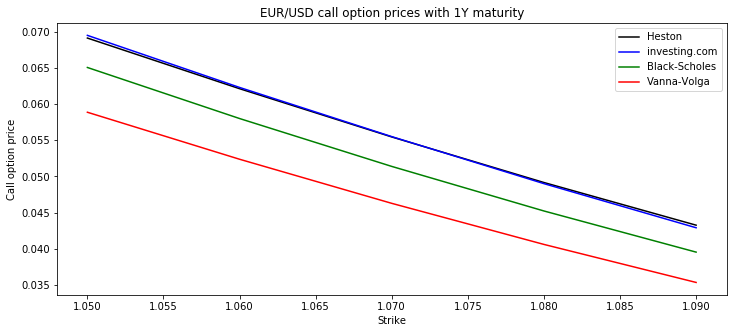

In [14]:
# Plot the four prices
plt.figure(1, figsize=(12,5))
plt.plot(dfres1Y.iloc[:,0],dfres1Y.iloc[:,1],'k-',
        dfres1Y.iloc[:,0],dfres1Y.iloc[:,2],'b-',
        dfres1Y.iloc[:,0],dfres1Y.iloc[:,3],'g-',
        dfres1Y.iloc[:,0],dfres1Y.iloc[:,4],'r-')
plt.title("EUR/USD call option prices with 1Y maturity")
plt.xlabel("Strike")
plt.ylabel("Call option price")
plt.legend(['Heston','investing.com','Black-Scholes','Vanna-Volga'],loc='best')
plt.show()